# Data Likelihood Without First Recall
In the datasets I've considered, CMR often unique struggles to account for the first recall a subject makes in a trial. In likelihood-based fitting, this difficulty can throw off the parameter search process, driving the model to fail to adequately fit to other important phenomena such as the lag-contiguity and serial position effects. 

We'll demo some fitting and simulation code that treats the distribution of first recalls as static events, configuring parameter values and generating data for downstream analysis without weighting or varying it. This enables us to neatly examine the model's ability to account for other features of datasets.

## Likelihood Functions
Differences from original functions:
- `likelihood` initialized with one fewer column since one less item is recalled
- `likelihood` only populated with a value for events after `recall_index` 0
- column `recall_index-1` instead of `recall_index` is populated with each likelihood value since we skip 0.

Important commonalities:
- First recall event is still simulated each time as in original function

In [1]:
import numpy as np
from numba import njit, prange
from compmemlearn.models import Classic_CMR
from numba.typed import Dict
from numba.core import types

@njit(fastmath=True, nogil=True, parallel=True)
def murdock_data_likelihood(data_to_fit, item_counts, model_class, parameters):

    result = 0.0
    for i in prange(len(item_counts)):
        item_count = item_counts[i]
        trials = data_to_fit[i]
        likelihood = np.ones((len(trials), item_count-1))

        model = model_class(item_count, item_count, parameters)
        model.experience(model.items)

        for trial_index in range(len(trials)):
            trial = trials[trial_index]

            model.force_recall()
            for recall_index in range(len(trial) + 1):

                # identify index of item recalled; if zero then recall is over
                if recall_index == len(trial) and len(trial) < item_count:
                    recall = 0
                else:
                    recall = trial[recall_index]

                # store probability of and simulate recall of indexed item 
                if recall_index > 0:
                    likelihood[trial_index, recall_index-1] = \
                        model.outcome_probabilities()[recall] + 10e-7
                
                if recall == 0:
                    break
                model.force_recall(recall)

            # reset model to its pre-retrieval (but post-encoding) state
            model.force_recall(0)
        
        result -= np.sum(np.log(likelihood))

    return result

def murdock_objective_function(data_to_fit, item_counts, model_class, fixed_parameters, free_parameters):
    """
    Configures cmr_likelihood for search over specified free/fixed parameters.
    """

    parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
    for name, value in fixed_parameters.items():
        parameters[name] = value
    
    def objective_function(x):
        for i in range(len(free_parameters)):
            parameters[free_parameters[i]] = x[i]
        return murdock_data_likelihood(data_to_fit, item_counts, model_class, parameters)

    return objective_function

In [2]:
import numpy as np
from numba import njit, prange
from compmemlearn.models import Classic_CMR
from numba.typed import Dict
from numba.core import types

@njit(fastmath=True, nogil=True, parallel=True)
def lohnas_data_likelihood(trials, presentations, model_class, parameters):

    list_length = len(presentations[0])
    likelihood = np.ones((len(trials), list_length-1)) 

    for trial_index in prange(len(trials)):

        item_count = np.max(presentations[trial_index])+1
        trial = trials[trial_index]
        model = model_class(item_count, list_length, parameters)
        model.experience(model.items[presentations[trial_index]])

        model.force_recall()
        for recall_index in range(len(trial) + 1):

            # identify index of item recalled; if zero then recall is over
            if recall_index == len(trial) and len(trial) < item_count:
                recall = 0
            elif trial[recall_index] == 0:
                recall = 0
            else:
                recall = presentations[trial_index][trial[recall_index]-1] + 1

            # store probability of and simulate recalling item with this index
            if recall_index > 0:                        
                likelihood[trial_index, recall_index-1] = \
                    model.outcome_probabilities()[recall] + 10e-7

            if recall == 0:
                break
            model.force_recall(recall)

        # reset model to its pre-retrieval (but post-encoding) state
        model.force_recall(0)

    return -np.sum(np.log(likelihood))

def lohnas_objective_function(data_to_fit, presentations, model_class, fixed_parameters, free_parameters):

    """
    Generates and returns an objective function for input to support search 
    through parameter space for model fit using an optimization function.

    Returns a function that accepts a vector x specifying arbitrary values for 
    free parameters and returns evaluation of likelihood using the model 
    class, all parameters, and provided data.
    """

    parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
    for name, value in fixed_parameters.items():
        parameters[name] = value

    def objective_function(x):
        for i in range(len(free_parameters)):
            parameters[free_parameters[i]] = x[i]
        return lohnas_data_likelihood(data_to_fit, presentations, model_class, parameters)

    return objective_function

## Simulation Functions
We want to make sure we are always simulating the first recalls that correspond to the datasets we fit the model to. Using our `force_recall` function should make that work. We'll add support for a `first_recall_item` array argument that identifies for each experiment trial a first recall to simulate. Like the values in our `trials` arrays, the values should be one-indexed.

In [3]:
import pandas as pd
from psifr import fr
import numpy as np
from numba import int32
from numba import njit

def simulate_df(model, experiment_count, first_recall_item=np.array([])):
    """
    Initialize a model with specified parameters and experience sequences and 
    then populate a psifr-formatted dataframe with the outcomes of performing `free recall`. 
    
    **Required model attributes**:
    - item_count: specifies number of items encoded into memory
    - context: vector representing an internal contextual state
    - experience: adding a new trace to the memory model
    - free_recall: function that freely recalls a given number of items or until recall stops
    """
    
    # encode items
    model.experience(model.items)

    # simulate retrieval for the specified number of times, tracking results in df
    trial_count = experiment_count
    if first_recall_item.size > 0:
        trial_count = experiment_count * first_recall_item.size
    
    data = []
    for trial_index in range(trial_count):
        data += [[trial_index, 0, 'study', i + 1, i] for i in range(model.item_count)]
    for trial_index in range(trial_count):
        if first_recall_item.size > 0:
            experiment = int(trial_index/first_recall_item.size)
            model.force_recall(first_recall_item[trial_index - (experiment * first_recall_item.size)])
        data += [[trial_index, 0, 'recall', i + 1, o] for i, o in enumerate(model.free_recall())]
    data = pd.DataFrame(data, columns=['subject', 'list', 'trial_type', 'position', 'item'])
    merged = fr.merge_free_recall(data)
    
    return merged

simulate_data = simulate_df

In [4]:
@njit(fastmath=True, nogil=True)
def simulate_array(model, experiment_count, first_recall_item=np.array([])):
    
    # encode items
    model.experience(model.items)

    # simulate retrieval for the specified number of times, tracking results in array
    if first_recall_item.size > 0:
        experiment_count *= first_recall_item.size
    trials = np.zeros((experiment_count, len(model.items)), dtype=int32)
    
    for trial_index in range(len(trials)):
        
        if first_recall_item.size > 0:
            experiment = int(trial_index/first_recall_item.size)
            model.force_recall(
                first_recall_item[trial_index - (
                    experiment * first_recall_item.size)])
        
        recalled = model.free_recall()
        trials[trial_index, :len(recalled)] = recalled + 1
        
    return trials

In [26]:
@njit(nogil=True)
def simulate_array_from_presentations(
    model_class, parameters, presentations, experiment_count,  first_recall_item=np.array([])):

    # simulate retrieval for the specified number of times, tracking results in trials array
    trials = np.zeros((experiment_count * len(presentations), np.max(presentations)+1), dtype=int32)
    
    for experiment in range(experiment_count):
        for trial_index in range(len(presentations)):
        
            # retrieve presentation sequence for this trial and measure number of unique items
            presentation = presentations[trial_index]
            item_count = np.max(presentation)+1
            
            # simulate recall and identify first study position of each recalled item
            model = model_class(item_count, len(presentation), parameters)
            model.experience(model.items[presentation])
            
            if first_recall_item.size > 0:
                model.force_recall(first_recall_item[trial_index])
            
            recalled = model.free_recall()
            
            for i in range(len(recalled)):
                trials[experiment*len(presentations) + trial_index, i] = find_first(recalled[i], presentation) + 1
    
    return trials

@njit(nogil=True)
def find_first(item, vec):
    """return the index of the first occurence of item in vec"""
    for i in range(len(vec)):
        if item == vec[i]:
            return i
    return -1

## Fitting Condition 1 of Lohnas Dataset With Both Likelihood Functions

In [6]:
from compmemlearn.datasets import prepare_murdock1962_data, prepare_murdock1970_data, prepare_lohnas2014_data

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../data/repFR.mat')

free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)


lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = (
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
)

@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

### Loading and Optimizing Along Cost Function

In [7]:
from scipy.optimize import differential_evolution
import numpy as np


# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = lohnas_objective_function(
    trials[list_types == 1], 
    presentations[list_types == 1], 
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    free_parameters)

lohnas_result = differential_evolution(cost_function, bounds, disp=True)
print(lohnas_result)

differential_evolution step 1: f(x)= 24877.6
differential_evolution step 2: f(x)= 22147
differential_evolution step 3: f(x)= 22147
differential_evolution step 4: f(x)= 21216.5
differential_evolution step 5: f(x)= 19343.9
differential_evolution step 6: f(x)= 19343.9
differential_evolution step 7: f(x)= 19343.9
differential_evolution step 8: f(x)= 19343.9
differential_evolution step 9: f(x)= 19343.9
differential_evolution step 10: f(x)= 19343.9
differential_evolution step 11: f(x)= 19343.9
differential_evolution step 12: f(x)= 19136.3
differential_evolution step 13: f(x)= 18672.3
differential_evolution step 14: f(x)= 17729.3
differential_evolution step 15: f(x)= 17729.3
differential_evolution step 16: f(x)= 17729.3
differential_evolution step 17: f(x)= 17729.3
differential_evolution step 18: f(x)= 17729.3
differential_evolution step 19: f(x)= 17729.3
differential_evolution step 20: f(x)= 17640
differential_evolution step 21: f(x)= 17640
differential_evolution step 22: f(x)= 17640
differe

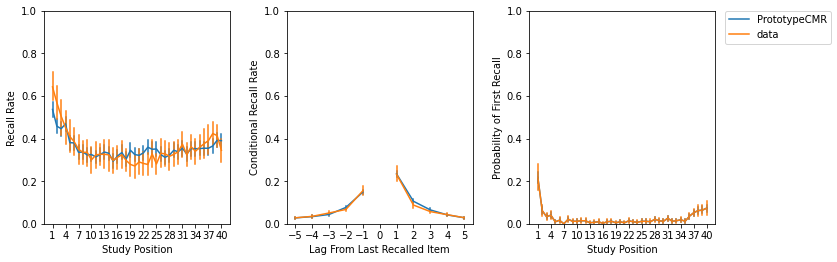

In [8]:
from compmemlearn.fitting import apply_and_concatenate
import seaborn as sns
import matplotlib.pyplot as plt

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(lohnas_result.x)):
    fitted_parameters[free_parameters[i]] = lohnas_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model0 = Classic_CMR(40, 40, fitted_parameters)

sim_df0 = simulate_df(model0, 2, trials[list_types==1][:, 0])
true_df0 = events.loc[events.condition==1]

cmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['PrototypeCMR', 'data'])
cmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr0 = cmr_pfr0.query('output <= 1')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12/3), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, list_length+1, 3))
axes[0].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2], hue='source', legend=True)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, list_length+1, 3))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)

### Let's compare this result with what we'd obtain if we fit using `murdock_data_likelihood`.

In [7]:
from scipy.optimize import differential_evolution
import numpy as np

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = murdock_objective_function(
    (trials[list_types==1], ), 
    (40, ), 
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    free_parameters)

murdock_result = differential_evolution(cost_function, bounds, disp=True)
print(murdock_result)

differential_evolution step 1: f(x)= 20429.6
differential_evolution step 2: f(x)= 20429.6
differential_evolution step 3: f(x)= 19671.6
differential_evolution step 4: f(x)= 19319
differential_evolution step 5: f(x)= 19319
differential_evolution step 6: f(x)= 19202.3
differential_evolution step 7: f(x)= 18877.5
differential_evolution step 8: f(x)= 18877.5
differential_evolution step 9: f(x)= 18366.8
differential_evolution step 10: f(x)= 18152.5
differential_evolution step 11: f(x)= 18152.5
differential_evolution step 12: f(x)= 18152.5
differential_evolution step 13: f(x)= 18009.6
differential_evolution step 14: f(x)= 18009.6
differential_evolution step 15: f(x)= 18009.6
differential_evolution step 16: f(x)= 17965.1
differential_evolution step 17: f(x)= 17557.8
differential_evolution step 18: f(x)= 17557.8
differential_evolution step 19: f(x)= 17557.8
differential_evolution step 20: f(x)= 17557.8
differential_evolution step 21: f(x)= 17504.4
differential_evolution step 22: f(x)= 17504.4
d

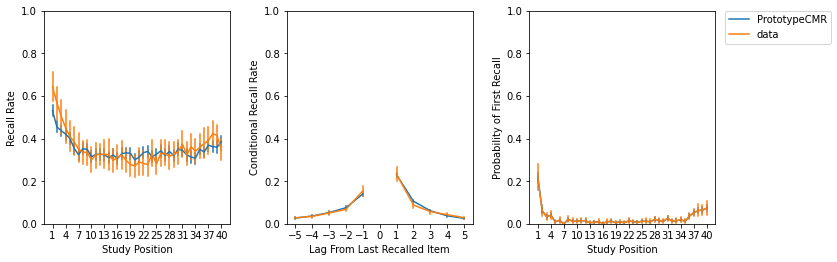

In [10]:
from compmemlearn.fitting import apply_and_concatenate
import seaborn as sns
import matplotlib.pyplot as plt

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(murdock_result.x)):
    fitted_parameters[free_parameters[i]] = murdock_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model0 = Classic_CMR(40, 40, fitted_parameters)

sim_df0 = simulate_df(model0, 3, trials[list_types==1][:, 0])
true_df0 = events.loc[events.condition==1]

cmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['PrototypeCMR', 'data'])
cmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr0 = cmr_pfr0.query('output <= 1')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12/3), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, list_length+1, 3))
axes[0].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2], hue='source', legend=True)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, list_length+1, 3))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)

## Fitting Murdock 1970 Dataset

In [15]:
trials, events, list_length = prepare_murdock1970_data('../data/mo1970.txt')

In [17]:
cost_function = murdock_objective_function(
    (trials, ),  
    (list_length, ),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    free_parameters)

murdock_result = differential_evolution(cost_function, bounds, disp=True)

differential_evolution step 1: f(x)= 24214.4
differential_evolution step 2: f(x)= 24214.4
differential_evolution step 3: f(x)= 23360.6
differential_evolution step 4: f(x)= 21132
differential_evolution step 5: f(x)= 20786.5
differential_evolution step 6: f(x)= 20786.5
differential_evolution step 7: f(x)= 20786.5
differential_evolution step 8: f(x)= 20786.5
differential_evolution step 9: f(x)= 20786.5
differential_evolution step 10: f(x)= 20512.7
differential_evolution step 11: f(x)= 20113
differential_evolution step 12: f(x)= 20113
differential_evolution step 13: f(x)= 20113
differential_evolution step 14: f(x)= 19287.5
differential_evolution step 15: f(x)= 19287.5
differential_evolution step 16: f(x)= 19287.5
differential_evolution step 17: f(x)= 19287.5
differential_evolution step 18: f(x)= 19287.5
differential_evolution step 19: f(x)= 19287.5
differential_evolution step 20: f(x)= 19287.5
differential_evolution step 21: f(x)= 19226.1
differential_evolution step 22: f(x)= 19226.1
diffe

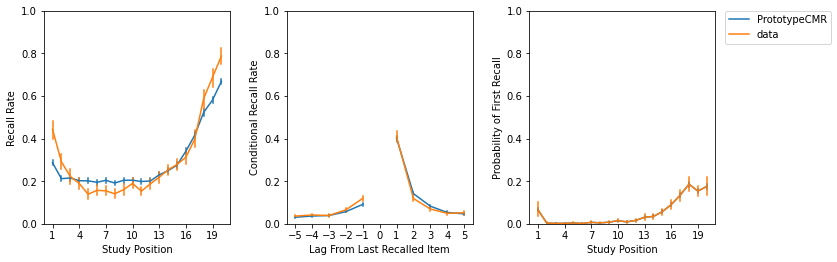

In [21]:
from compmemlearn.fitting import apply_and_concatenate
import seaborn as sns
import matplotlib.pyplot as plt

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(murdock_result.x)):
    fitted_parameters[free_parameters[i]] = murdock_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model0 = Classic_CMR(20, 20, fitted_parameters)

sim_df0 = simulate_df(model0, 3, trials[:, 0])
true_df0 = events

cmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['PrototypeCMR', 'data'])
cmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr0 = cmr_pfr0.query('output <= 1')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12/3), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, list_length+1, 3))
axes[0].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2], hue='source', legend=True)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, list_length+1, 3))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)

## Fitting to Mixed Lists in Lohnas 2014 Dataset

In [23]:
trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../data/repFR.mat')

### Loading and Optimizing Along Cost Function

In [24]:
from scipy.optimize import differential_evolution
import numpy as np

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = lohnas_objective_function(
    trials[list_types == 4], 
    presentations[list_types == 4], 
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    free_parameters)

lohnas_result = differential_evolution(cost_function, bounds, disp=True)
print(lohnas_result)

differential_evolution step 1: f(x)= 21482.9
differential_evolution step 2: f(x)= 20633.8
differential_evolution step 3: f(x)= 20633.8
differential_evolution step 4: f(x)= 18065
differential_evolution step 5: f(x)= 17230.4
differential_evolution step 6: f(x)= 17230.4
differential_evolution step 7: f(x)= 17230.4
differential_evolution step 8: f(x)= 17230.4
differential_evolution step 9: f(x)= 16951.5
differential_evolution step 10: f(x)= 16933
differential_evolution step 11: f(x)= 16933
differential_evolution step 12: f(x)= 16693.5
differential_evolution step 13: f(x)= 16627.6
differential_evolution step 14: f(x)= 16300.3
differential_evolution step 15: f(x)= 16265.7
differential_evolution step 16: f(x)= 16246
differential_evolution step 17: f(x)= 16153.1
differential_evolution step 18: f(x)= 16139.3
differential_evolution step 19: f(x)= 16114.7
differential_evolution step 20: f(x)= 16114.7
differential_evolution step 21: f(x)= 16027.8
differential_evolution step 22: f(x)= 16027.8
diffe

In [27]:
from compmemlearn.analyses import fast_rpl

fitted_parameters = Dict.empty(
    key_type=types.unicode_type, value_type=types.float64)
for j in range(len(lohnas_result.x)):
    fitted_parameters[free_parameters[j]] = lohnas_result.x[j]

fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

experiment_count = 1000
new_sim_array = simulate_array_from_presentations(
    init_cmr, fitted_parameters, presentations[list_types==4], 
    experiment_count, trials[list_types==4][:, 0])

In [28]:
import numpy.matlib

result = fast_rpl(np.matlib.repmat(presentations[list_types==4], experiment_count, 1), new_sim_array)
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
print(binned)

[0.34825544 0.44442143 0.49150357 0.50895238 0.50364762]


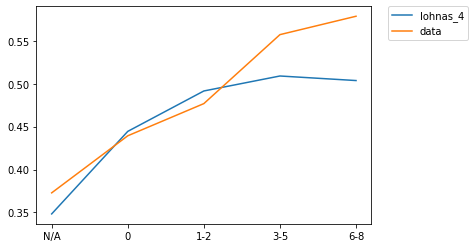

In [29]:
import matplotlib.pyplot as plt

fit_sources = ['lohnas_4']
fit_rpls = [binned]

for i in range(len(fit_sources)):
    plt.plot(fit_rpls[i], label=fit_sources[i])

result = fast_rpl(presentations[list_types==4], trials[list_types==4])
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
plt.plot(binned, label='data')
lags = ['N/A', '0', '1-2', '3-5', '6-8']
plt.xticks(np.arange(len(lags)), lags)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)